In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from scipy.interpolate import RBFInterpolator

For this project you will need Columbia Object Image Library (COIL-100) Dataset

The image set is the COIL-100 dataset, which contains 7200 images of 100 objects
Original data source and banner image: 
http://www1.cs.columbia.edu/CAVE/software/softlib/coil-100.php \
This dataset is intended for non-commercial research purposes only. When using this dataset, please cite: \
"Columbia Object Image Library (COIL-100)," \
S. A. Nene, S. K. Nayar and H. Murase, \
Technical Report CUCS-006-96, February 1996.

Download and store the image files in project's folder `data/coil-100/`

In [2]:
# function to display an image without axii, works with numpy arrays and PIL images
def imdisplay(im):
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x1076AC850>
Image shape:  (128, 128)
Image array shape:  (128, 128, 3)


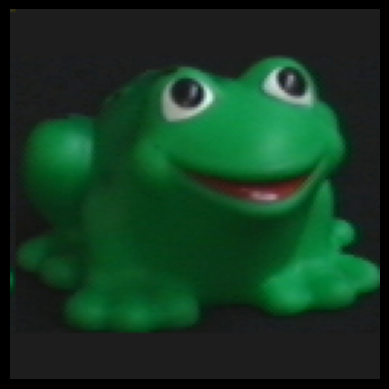

Image array shape:  (128, 128)


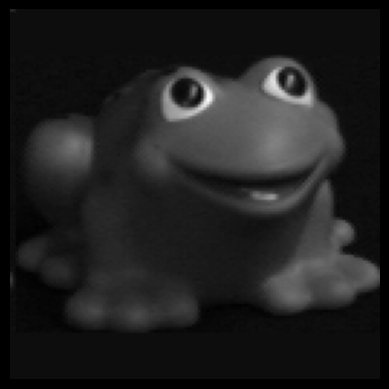

In [3]:
# Open an image file and display it
img_folder = "data/coil-100/"
with Image.open(img_folder + 'obj28__255.png') as img:
    print(img)
    shape = img.size
    print("Image shape: ", shape)
    img_ar = np.asarray(img)
    print("Image array shape: ", img_ar.shape)
    imdisplay(img)
    # convert to grayscale and display the image
    img = img.convert("L")
    img_ar = np.asarray(img)
    print("Image array shape: ", img_ar.shape)
    imdisplay(img)

## Part I: Image discrimination 

X shape:  (7200, 16384)
y shape:  (7200,)
Frog shape:  (72, 16384)


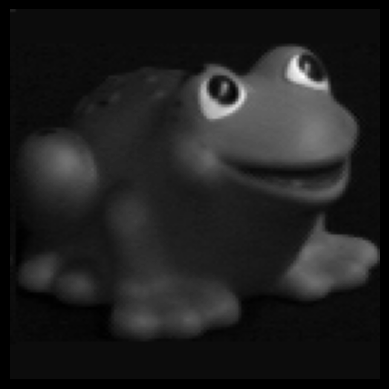

In [4]:
# Read all the images from the folder "coil-100"
# convert to grey scale, flatten and store in a numpy array as image vectors
# store the labels in a list
X = []
y = []
for file in os.listdir(img_folder):
    if file.endswith(".png"):
        with Image.open(img_folder + file) as img:
            img = img.convert("L")
            img_ar = np.asarray(img)
            X.append(img_ar.flatten())
            y.append(file.split("__")[0])
X_original = np.array(X)
y_original = np.array(y)
print("X shape: ", X_original.shape)
print("y shape: ", y_original.shape)
# display obj28 (frog) as array and image
frogs_index = np.where(y_original == 'obj28')
frogs = X_original[frogs_index]
print("Frog shape: ", frogs.shape)
imdisplay(frogs[3].reshape(shape))
N = X_original.shape[0] # Total number of images

In [5]:
# Normalization and centering
# Normalize each image vector to remove brightness variations
# (Frobenius norm: vector length = sqrt(sum of squares of coordinates))
X_original = X_original/np.linalg.norm(X_original, axis=1)[:, None]
# Check that the sum of all elements in each image vector is 1 (Total N vectors)
norm_sum = np.sum(np.linalg.norm(X_original, axis=1)[:, None])
print("Sum of all lengths of image vectors: ", norm_sum)
print(norm_sum == N)
# Since centering is done by substructing the mean of each object from images of that object, 
# we need to split the images into training and test sets to avoid data leaking.
# Later we need to substruct this mean from the test set as well.
# (I keep the train sets notation as X and y)
X, X_test, y, y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42)
print("Shapes of train and test sets:")
print("X: ", X.shape)
print("X_test: ", X_test.shape)
print("y: ", y.shape)
print("y_test: ", y_test.shape)
N_train = X.shape[0] # number of training images/vectors/samples
# Center the data by subtracting the mean of each object
X_mean = np.mean(X, axis=0)
X = X - X_mean

Sum of all lengths of image vectors:  7200.0
True
Shapes of train and test sets:
X:  (5760, 16384)
X_test:  (1440, 16384)
y:  (5760,)
y_test:  (1440,)


In [6]:
# Perform SVD on the data
# X = U*S*Vt, where U and Vt are orthogonal matrices and S is a diagonal matrix
# containing the singular values of X in decreasing order, the columns of U are the left singular vectors
# and the rows of Vt are the right singular vectors
print("X shape: ", X.shape)
U, S, Vt = np.linalg.svd(X, full_matrices=False)
print("U shape: ", U.shape)
print("S shape: ", S.shape)
print("Vt shape: ", Vt.shape)

X shape:  (5760, 16384)
U shape:  (5760, 5760)
S shape:  (5760,)
Vt shape:  (5760, 16384)


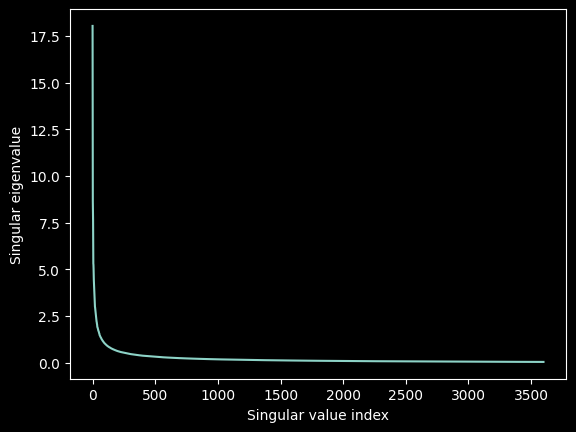

In [7]:
# There are N_train eigenvalues
# Display first M singular values
M = 3600
plt.plot(S[:M])
plt.xlabel("Singular value index")
plt.ylabel("Singular eigenvalue")
plt.show()

Approximation shape:  (5760, 16384)
Approximation degree (smaller is better):  0.15906626287429612


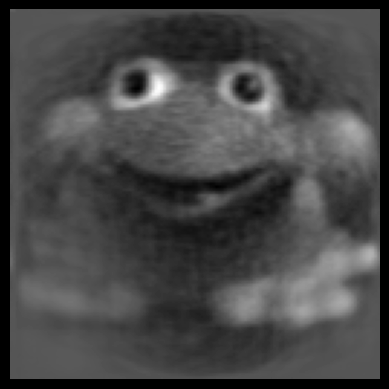

In [8]:
# Choose the number of principal components to keep, i.e. "rank of the approximation",
# by setting a threshold for the singular eigenvalues at k, ideally this threshold should be
# chosen somewhere after the signigicant drop in the singular values.
# (experiment with 5, 10, 15, 20 percent of the total number of singular values 
# if you are not sure, having anything below 30% and getting positive results is a already a good approximation)
k = 720
# Compute the approximation of X by the first k principal components
Uk, Sk, Vtk = U[:, :k], S[:k], Vt[:k, :]
X_trunc = Uk @ np.diag(Sk) @ Vtk
print("Approximation shape: ", X_trunc.shape)
# calculate the approximation error by the Frobenius norm
T = np.linalg.norm(X - X_trunc, ord='fro')/np.linalg.norm(X, ord='fro')
print("Approximation degree (smaller is better): ", T)
# Display the approximation of a frog image
frogs_index = np.where(y == 'obj28')
imdisplay(X_trunc[frogs_index][14].reshape(shape))

In [9]:
# Constructing manifolds for each object 
# By projecting each image of an object P onto truncated eigen space we get a set of points
# These points are fitted to a manifold correspoding to that object P using RBF interpolation
# First we construct classification vector for all objects

# Construct one-hot encoding for each object
Y = np.zeros((X.shape[0], 100))
for i in range(100):
    Y[y == f'obj{i+1}', i] = 1
print ("Y shape: ", Y.shape)
# Now we project each image onto the truncated eigen space
X_proj = X @ Vtk.T
print("Projected shape: ", X_proj.shape)
print(len(Y))
print(len(X_proj))
# Now we fit the projected points to a manifold using RBF interpolation
# Parameters for RBF interpolation should be chosen through cross-validation
rbf_interpolation = RBFInterpolator(X_proj, Y, kernel='gaussian', epsilon=2)

Y shape:  (5760, 100)
Projected shape:  (5760, 720)
5760
5760


In [10]:
# Some more processing is needed to get the test set ready
# Center the test set by subtracting the mean of the training set
X_test = X_test - X_mean
# Project the test set onto the truncated eigen space
X_test_proj = X_test @ Vtk.T
# Construct collapsed one-hot encoding for the test set
y_test_class = np.zeros_like(y_test, dtype=int)
for i in range(100):
    y_test_class[y_test == f'obj{i+1}'] = i + 1
print("y_test_class: ", y_test_class)

y_test_class:  [23 14 11 ...  2 59 36]


In [12]:
# Test the classifier on test data
class_pred = rbf_interpolation(X_test_proj)
print("Test class shape: ", class_pred.shape)
class_pred = np.argmax(class_pred, axis=1) + 1
accuracy = np.sum(class_pred == y_test_class)/len(y_test_class)
print("Accuracy: ", accuracy)


Test class shape:  (1440, 100)
Accuracy:  0.9875


### TODOs:
- [x] Object discrimination
- [-] Cross-validation
- [-] RBF epsilon tuning
- [-] Pose estimation


### References
1. Murase, H., Nayar, S.K. Visual learning and recognition of 3-d objects from appearance. Int J Comput Vision 14, 5–24 (1995). https://doi.org/10.1007/BF01421486

